In [4]:
from torchvision import datasets
import torch

In [5]:
data_path = './p1ch7/'
cifar10 = datasets.CIFAR10(data_path,train=True,download=True)
cifar10_val = datasets.CIFAR10(data_path,train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
img,label = cifar10[123]
img,label

(<PIL.Image.Image image mode=RGB size=32x32>, 2)

PIL.Image.Image

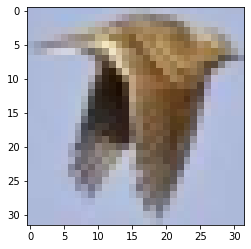

In [7]:
import matplotlib.pyplot as plt
plt.imshow(img)
type(img)

In [8]:
from torchvision import transforms

In [40]:
tensor_cifar10 = datasets.CIFAR10(data_path,train=True, download=False, transform = transforms.ToTensor())
tensor_val_cifar10 = datasets.CIFAR10(data_path,train=False,download=False,transform = transforms.ToTensor())

In [48]:
imgs = torch.stack([img_t for img_t,_ in tensor_cifar10],dim = 3)
val_imgs = torch.stack([img_t for img_t,_ in tensor_val_cifar10],dim = 3)

In [51]:
avg = imgs.view(3,-1).mean(1)
std = imgs.view(3,-1).std(1)
val_avg = val_imgs.view(3,-1).mean(1)
val_std = val_imgs.view(3,-1).std(1)

In [52]:
transformed_cifar10 = datasets.CIFAR10(data_path,train=True,download=False,transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = avg, std = std)
]))

tensor_val_cifar10 = datasets.CIFAR10(data_path,train=False,download=False,transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=val_avg,std=val_std)
]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


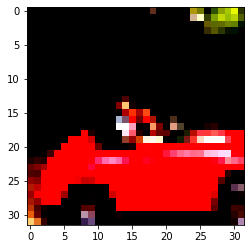

In [17]:
img_t,_ = transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))


In [53]:
label_map = {0:0,2:1}
class_names = ["airplane","bird"]
cifar2 = [(img,label_map[label]) for img,label in transformed_cifar10 if label in [0,2]]
cifar2_val = [(img,label_map[label]) for img,label in tensor_val_cifar10 if label in [0,2]]

In [19]:
import torch.nn as nn

In [27]:
n_out =2
model = nn.Sequential(
    nn.Linear(3072,512),
    nn.Tanh(),
    nn.Linear(512,n_out),
    nn.LogSoftmax(dim=1)
)

In [29]:
img,_ = cifar2[0]
img_batch = img.view(-1).unsqueeze(0)
out = model(img_batch)
loss = nn.NLLLoss()

In [30]:
_,index = torch.max(out,dim = 1)
index

tensor([1])

In [31]:
img,label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out,torch.tensor([label]))

tensor(0.6306, grad_fn=<NllLossBackward0>)

In [32]:
label

1

In [34]:
model = nn.Sequential(
    nn.Linear(3072,512),
    nn.Tanh(),
    nn.Linear(512,2),
    nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2
train_loader = torch.utils.data.DataLoader(cifar2,shuffle=True,batch_size = 64)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

In [37]:
n_epoches = 100

for epoch in range(n_epoches):
    for imgs,labels in train_loader:
        batch_shape = imgs.shape[0]
        output = model(imgs.view(batch_shape,-1))
        loss = loss_fn(output,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch %d, Loss: %f" %(epoch,float(loss)))

Epoch 0, Loss: 0.523135
Epoch 1, Loss: 0.442396
Epoch 2, Loss: 0.415274
Epoch 3, Loss: 0.653630
Epoch 4, Loss: 0.263889
Epoch 5, Loss: 0.313165
Epoch 6, Loss: 0.324467
Epoch 7, Loss: 0.222047
Epoch 8, Loss: 0.524172
Epoch 9, Loss: 0.515321
Epoch 10, Loss: 0.188217
Epoch 11, Loss: 0.214073
Epoch 12, Loss: 0.238223
Epoch 13, Loss: 0.297283
Epoch 14, Loss: 0.227936
Epoch 15, Loss: 0.661978
Epoch 16, Loss: 0.334166
Epoch 17, Loss: 0.453081
Epoch 18, Loss: 0.275257
Epoch 19, Loss: 0.439589
Epoch 20, Loss: 0.149624
Epoch 21, Loss: 0.260662
Epoch 22, Loss: 0.337753
Epoch 23, Loss: 0.162311
Epoch 24, Loss: 0.378485
Epoch 25, Loss: 0.163586
Epoch 26, Loss: 0.262390
Epoch 27, Loss: 0.181054
Epoch 28, Loss: 0.111509
Epoch 29, Loss: 0.119438
Epoch 30, Loss: 0.120673
Epoch 31, Loss: 0.304757
Epoch 32, Loss: 0.175471
Epoch 33, Loss: 0.146863
Epoch 34, Loss: 0.161982
Epoch 35, Loss: 0.187379
Epoch 36, Loss: 0.267984
Epoch 37, Loss: 0.176016
Epoch 38, Loss: 0.150373
Epoch 39, Loss: 0.198065
Epoch 40, 

In [54]:
val_loader = torch.utils.data.DataLoader(cifar2_val,shuffle=False,batch_size = 64)
correct = 0
total = 0
with torch.no_grad():
    for imgs,labels in val_loader:
        output = model(imgs.view(imgs.shape[0],-1))
        _,predicted = torch.max(output,dim = 1)
        total+= imgs.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy %f" % (correct/total))

Accuracy 0.815000


In [55]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad ==True]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])